# Machine Learning Final Project
## Gradient Boosting for Exam Performance Prediction

**Student Names:**
1.   2023-CS-454 - Wafa Abbas
2.   2023-CS-456 - Abdul Ahad
3.   2023-CS-463 - Abdul Rehman
4.   2023-CS-480 - Zaman
5.   2023-CS-486 - HAMMAD


**Course:** Machine Learning  
**Semester:** 5th  

---

### Project Overview
This notebook implements a complete machine learning pipeline using Gradient Boosting Regression to predict exam performance. The project is divided into three phases:
- **Phase A:** Model Selection and Hyperparameter Tuning
- **Phase B:** Model Validation using Cross-Validation
- **Phase C:** Final Model Training and Test Evaluation

All steps follow the teacher's instructions exactly.

## Import Required Libraries

We import all necessary libraries for data manipulation, machine learning, visualization, and evaluation metrics.

In [6]:
# Data manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix

# Evaluation metric for ordinal classification
from sklearn.metrics import cohen_kappa_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("All libraries imported successfully!")

All libraries imported successfully!


---
#  DATA PREPARATION

In this section, we load the dataset, encode categorical variables, and split the data into training and testing sets.

## Step 1: Load Dataset

**What:** Load the Excel file containing the exam performance data.  
**Why:** We need to import the raw data before we can process and analyze it.

In [7]:
# Load the dataset from Excel file
# Note: Upload your Data_Project.xlsx file to Colab before running this cell
df = pd.read_excel('Data_Project.xlsx')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())

Dataset Shape: (72, 7)

Column Names:
['Gender', 'Age (Years)', 'Household size', 'Marital Status ', 'Child in Family', 'Experience', 'Performance']

First 5 rows:
   Gender Age (Years) Household size Marital Status  Child in Family  \
0  Female     31 - 40           Four         Married             Yes   
1    Male     21 - 30         Single          Single              No   
2    Male     31 - 40           Four         Married             Yes   
3    Male     21 - 30           Four          Single              No   
4    Male     21 - 30           Four          Single              No   

   Experience        Performance  
0           8   a little worse    
1           8              same   
2           8   a little worse    
3           2  a little better    
4           7  a little better    

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           ---------

## Step 2: Encode Age Column

**What:** Convert the Age column from categorical ranges to numeric codes (1, 2, 3, 4).  
**Why:** Machine learning models require numeric input. We use category codes to preserve the ordinal nature of age ranges.

In [8]:
# Convert Age (Years) to categorical type and extract codes
# This will assign numeric codes: 21-30=0, 31-40=1, 41-50=2, 51-60=3
# We add 1 to get codes starting from 1 instead of 0
df['Age'] = pd.Categorical(df['Age (Years)']).codes + 1

# Display the mapping
print("Age Encoding Mapping:")
age_mapping = df[['Age (Years)', 'Age']].drop_duplicates().sort_values('Age')
print(age_mapping)
print("\nAge distribution:")
print(df['Age'].value_counts().sort_index())

Age Encoding Mapping:
   Age (Years)  Age
1      21 - 30    1
0      31 - 40    2
69     41 - 50    3
64     51 - 60    4

Age distribution:
Age
1    45
2    23
3     1
4     3
Name: count, dtype: int64


## Step 3: Encode Exam Performance (Target Variable)

**What:** Convert the Performance column to numeric values according to the mapping:  
- 'much worse' → 1  
- 'a little worse' → 2  
- 'same' → 3  
- 'a little better' → 4  
- 'a lot better' → 5  
- 'much better' → 5  

**Why:** This creates our target variable for prediction. The encoding preserves the ordinal relationship between performance levels.

In [9]:
# Clean whitespace from Performance column
df['Performance'] = df['Performance'].str.strip()

# Define the encoding mapping
performance_mapping = {
    'much worse': 1,
    'a little worse': 2,
    'same': 3,
    'a little better': 4,
    'a lot better': 5,
    'much better': 5
}

# Apply the mapping
df['Exam_Performance'] = df['Performance'].map(performance_mapping)

# Verify encoding
print("Performance Encoding:")
print(df[['Performance', 'Exam_Performance']].drop_duplicates().sort_values('Exam_Performance'))
print("\nExam_Performance distribution:")
print(df['Exam_Performance'].value_counts().sort_index())
print("\nMissing values in Exam_Performance:", df['Exam_Performance'].isnull().sum())

Performance Encoding:
        Performance  Exam_Performance
65       much worse                 1
0    a little worse                 2
1              same                 3
3   a little better                 4
6      a lot better                 5
64      much better                 5

Exam_Performance distribution:
Exam_Performance
1     4
2    18
3    14
4    20
5    16
Name: count, dtype: int64

Missing values in Exam_Performance: 0


## Step 4: Prepare Feature Variables

**What:** Clean and encode all predictor variables.  
**Why:** We need to convert all categorical variables to numeric format for the machine learning model.

In [10]:
# Clean column names (remove trailing spaces)
df.columns = df.columns.str.strip()

# Encode Gender (Male=1, Female=0)
df['Gender_Encoded'] = (df['Gender'] == 'Male').astype(int)

# Clean and encode Household size
df['Household size'] = df['Household size'].str.strip()
df['Household_Size'] = pd.Categorical(df['Household size']).codes + 1

# Clean and encode Marital Status
df['Marital Status'] = df['Marital Status'].str.strip()
df['Marital_Status_Encoded'] = pd.Categorical(df['Marital Status']).codes + 1

# Clean and encode Child in Family
df['Child in Family'] = df['Child in Family'].str.strip()
df['Child_in_Family'] = pd.Categorical(df['Child in Family']).codes + 1

# Experience is already numeric, just copy it
df['Experience_Encoded'] = df['Experience']

print("Feature Encoding Summary:")
print("\nGender:")
print(df[['Gender', 'Gender_Encoded']].drop_duplicates())
print("\nHousehold Size:")
print(df[['Household size', 'Household_Size']].drop_duplicates().sort_values('Household_Size'))
print("\nMarital Status:")
print(df[['Marital Status', 'Marital_Status_Encoded']].drop_duplicates().sort_values('Marital_Status_Encoded'))
print("\nChild in Family:")
print(df[['Child in Family', 'Child_in_Family']].drop_duplicates().sort_values('Child_in_Family'))
print("\nExperience range:", df['Experience_Encoded'].min(), "-", df['Experience_Encoded'].max())

Feature Encoding Summary:

Gender:
   Gender  Gender_Encoded
0  Female               0
1    Male               1

Household Size:
   Household size  Household_Size
0            Four               1
1          Single               2
9           Three               3
12            Two               4

Marital Status:
  Marital Status  Marital_Status_Encoded
0        Married                       1
1         Single                       2

Child in Family:
  Child in Family  Child_in_Family
1              No                1
0             Yes                2

Experience range: 1 - 12


## Step 5: Train-Test Split

**What:** Split the dataset into 70% training and 30% testing sets with `random_state=42`.  
**Why:** We need separate data for training and final evaluation. The test set will remain untouched until Phase C to prevent data leakage and ensure unbiased evaluation.

In [11]:
# Define all predictor variables (6 features)
all_features = ['Age', 'Gender_Encoded', 'Household_Size', 
                'Marital_Status_Encoded', 'Child_in_Family', 'Experience_Encoded']

# Define baseline predictors (2 features)
baseline_features = ['Age', 'Child_in_Family']

# Prepare feature matrix (X) and target vector (y)
X = df[all_features]
y = df['Exam_Performance']

# Perform train-test split (70% train, 30% test, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42,
    stratify=y  # Stratify to maintain class distribution
)

print("Train-Test Split Summary:")
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")
print("\nTarget distribution in training set:")
print(y_train.value_counts().sort_index())
print("\nTarget distribution in test set:")
print(y_test.value_counts().sort_index())
print("\n⚠️ Test set is now locked and will not be used until Phase C!")

Train-Test Split Summary:
Total samples: 72
Training samples: 50 (69.4%)
Testing samples: 22 (30.6%)

Target distribution in training set:
Exam_Performance
1     3
2    12
3    10
4    14
5    11
Name: count, dtype: int64

Target distribution in test set:
Exam_Performance
1    1
2    6
3    4
4    6
5    5
Name: count, dtype: int64

⚠️ Test set is now locked and will not be used until Phase C!


---
#  PHASE A: MODEL SELECTION

In this phase, we:
1. Build a baseline Gradient Boosting model with 2 features
2. Build a model with all 6 features
3. Perform hyperparameter tuning using GridSearchCV
4. Select the best model based on cross-validation performance

**Important:** All work in Phase A uses only the training data.

## Step 1: Baseline Gradient Boosting Model

**What:** Train a Gradient Boosting Regressor using only Age and Child in Family as predictors.  
**Why:** This establishes a baseline performance to compare against more complex models. We use default parameters: n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42.

In [12]:
# Initialize baseline model with specified parameters
baseline_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Prepare baseline features (Age and Child in Family only)
X_train_baseline = X_train[baseline_features]

# Train the model
baseline_model.fit(X_train_baseline, y_train)

# Make predictions on training data
y_train_pred_baseline = baseline_model.predict(X_train_baseline)

# Round predictions to nearest integer and clip to [1, 5]
y_train_pred_baseline_rounded = np.clip(np.round(y_train_pred_baseline), 1, 5)

# Calculate metrics
baseline_train_mae = mean_absolute_error(y_train, y_train_pred_baseline_rounded)
baseline_train_accuracy = accuracy_score(y_train, y_train_pred_baseline_rounded)

print("="*60)
print("BASELINE MODEL RESULTS (Age + Child in Family)")
print("="*60)
print(f"Features used: {baseline_features}")
print(f"Number of features: {len(baseline_features)}")
print(f"\nTraining MAE: {baseline_train_mae:.4f}")
print(f"Training Accuracy: {baseline_train_accuracy:.4f} ({baseline_train_accuracy*100:.2f}%)")
print(f"\nTraining Loss (MSE): {baseline_model.train_score_[-1]:.4f}")
print("="*60)

BASELINE MODEL RESULTS (Age + Child in Family)
Features used: ['Age', 'Child_in_Family']
Number of features: 2

Training MAE: 0.7800
Training Accuracy: 0.4000 (40.00%)

Training Loss (MSE): 1.0913


## Step 2: All Variables Model

**What:** Train a Gradient Boosting model using all 6 predictor variables.  
**Why:** We want to determine if additional features improve model performance. We'll compare training loss and examine feature importance to decide which model to use going forward.

In [13]:
# Initialize model with all features using same parameters
all_vars_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Train the model with all features
all_vars_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred_all = all_vars_model.predict(X_train)

# Round predictions to nearest integer and clip to [1, 5]
y_train_pred_all_rounded = np.clip(np.round(y_train_pred_all), 1, 5)

# Calculate metrics
all_vars_train_mae = mean_absolute_error(y_train, y_train_pred_all_rounded)
all_vars_train_accuracy = accuracy_score(y_train, y_train_pred_all_rounded)

print("="*60)
print("ALL VARIABLES MODEL RESULTS")
print("="*60)
print(f"Features used: {all_features}")
print(f"Number of features: {len(all_features)}")
print(f"\nTraining MAE: {all_vars_train_mae:.4f}")
print(f"Training Accuracy: {all_vars_train_accuracy:.4f} ({all_vars_train_accuracy*100:.2f}%)")
print(f"\nTraining Loss (MSE): {all_vars_model.train_score_[-1]:.4f}")
print("="*60)

ALL VARIABLES MODEL RESULTS
Features used: ['Age', 'Gender_Encoded', 'Household_Size', 'Marital_Status_Encoded', 'Child_in_Family', 'Experience_Encoded']
Number of features: 6

Training MAE: 0.0800
Training Accuracy: 0.9200 (92.00%)

Training Loss (MSE): 0.0803


### Model Comparison and Feature Importance

**What:** Compare the baseline and all-variables models, and examine feature importance.  
**Why:** This helps us decide which features to include in the final model.

MODEL COMPARISON
Metric                    Baseline        All Variables  
------------------------------------------------------------
Number of Features        2               6              
Training MAE              0.7800          0.0800         
Training Accuracy         0.4000          0.9200         
Training Loss (MSE)       1.0913          0.0803         

IMPROVEMENT ANALYSIS:
MAE Improvement: 0.7000 (better)
Accuracy Improvement: 0.5200 (52.00%)

FEATURE IMPORTANCE (Total Gain)
               Feature  Importance
    Experience_Encoded      0.3206
                   Age      0.2461
        Household_Size      0.1726
Marital_Status_Encoded      0.1325
       Child_in_Family      0.0898
        Gender_Encoded      0.0383


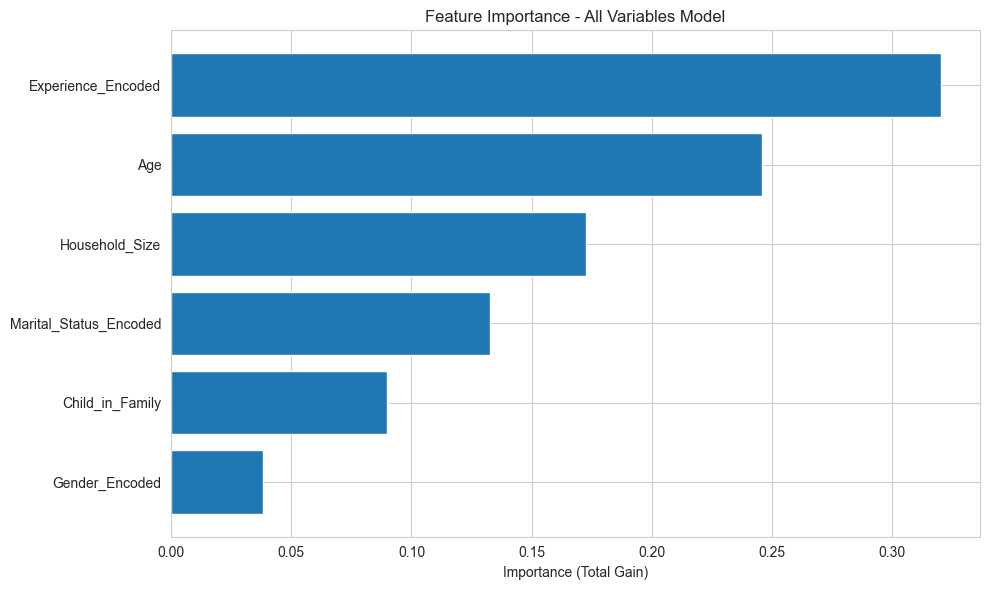


DECISION
✅ The All Variables Model performs better than the Baseline Model.
   - Lower MAE by 0.7000
   - Higher Accuracy by 52.00%

🎯 We will proceed with the All Variables Model (6 features) for hyperparameter tuning.


In [14]:
# Comparison table
print("="*60)
print("MODEL COMPARISON")
print("="*60)
print(f"{'Metric':<25} {'Baseline':<15} {'All Variables':<15}")
print("-"*60)
print(f"{'Number of Features':<25} {len(baseline_features):<15} {len(all_features):<15}")
print(f"{'Training MAE':<25} {baseline_train_mae:<15.4f} {all_vars_train_mae:<15.4f}")
print(f"{'Training Accuracy':<25} {baseline_train_accuracy:<15.4f} {all_vars_train_accuracy:<15.4f}")
print(f"{'Training Loss (MSE)':<25} {baseline_model.train_score_[-1]:<15.4f} {all_vars_model.train_score_[-1]:<15.4f}")
print("="*60)

# Calculate improvement
mae_improvement = baseline_train_mae - all_vars_train_mae
accuracy_improvement = all_vars_train_accuracy - baseline_train_accuracy

print("\nIMPROVEMENT ANALYSIS:")
print(f"MAE Improvement: {mae_improvement:.4f} ({'better' if mae_improvement > 0 else 'worse'})")
print(f"Accuracy Improvement: {accuracy_improvement:.4f} ({accuracy_improvement*100:.2f}%)")

# Feature importance for all variables model
print("\n" + "="*60)
print("FEATURE IMPORTANCE (Total Gain)")
print("="*60)
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': all_vars_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.to_string(index=False))
print("="*60)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance (Total Gain)')
plt.title('Feature Importance - All Variables Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Decision
print("\n" + "="*60)
print("DECISION")
print("="*60)
if all_vars_train_mae < baseline_train_mae:
    print("✅ The All Variables Model performs better than the Baseline Model.")
    print(f"   - Lower MAE by {mae_improvement:.4f}")
    print(f"   - Higher Accuracy by {accuracy_improvement*100:.2f}%")
    print("\n🎯 We will proceed with the All Variables Model (6 features) for hyperparameter tuning.")
    selected_features = all_features
else:
    print("⚠️ The Baseline Model performs equally well or better.")
    print("🎯 We will proceed with the Baseline Model (2 features) for hyperparameter tuning.")
    selected_features = baseline_features
print("="*60)

## Step 3: Hyperparameter Tuning with GridSearchCV

**What:** Use GridSearchCV with Stratified 5-Fold Cross-Validation to find the best hyperparameters.  
**Why:** Systematic hyperparameter tuning helps us find the optimal model configuration. We use stratified K-fold to ensure each fold maintains the same class distribution as the original dataset.

In [15]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [1, 2, 3],
    'subsample': [0.7, 0.9],
    'min_samples_leaf': [5, 10]
}

print("Hyperparameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal parameter combinations to test: {total_combinations}")
print(f"With 5-fold CV, total fits: {total_combinations * 5}")

# Initialize Stratified K-Fold (stratify on Exam_Performance)
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize base model
gb_model = GradientBoostingRegressor(random_state=42)

# Prepare features based on previous decision
X_train_selected = X_train[selected_features]

# Initialize GridSearchCV
# Scoring: negative MAE (GridSearchCV maximizes, so we negate MAE)
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=stratified_cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,  # Use all available cores
    verbose=2,
    return_train_score=True
)

print("\n🔍 Starting GridSearchCV...")
print("This may take a few minutes...\n")

# Fit GridSearchCV
grid_search.fit(X_train_selected, y_train)

print("\n✅ GridSearchCV completed!")

Hyperparameter Grid:
  n_estimators: [100, 300, 500]
  learning_rate: [0.01, 0.05, 0.1]
  max_depth: [1, 2, 3]
  subsample: [0.7, 0.9]
  min_samples_leaf: [5, 10]

Total parameter combinations to test: 108
With 5-fold CV, total fits: 540

🔍 Starting GridSearchCV...
This may take a few minutes...

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\hP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



✅ GridSearchCV completed!


### GridSearchCV Results

**What:** Display the best parameters and top performing configurations.  
**Why:** This helps us understand which hyperparameters work best for our dataset.

In [16]:
# Extract results
results_df = pd.DataFrame(grid_search.cv_results_)

# Display best parameters
print("="*60)
print("BEST HYPERPARAMETERS FROM GRIDSEARCHCV")
print("="*60)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"\nBest CV MAE: {-grid_search.best_score_:.4f}")
print("="*60)

# Top 10 configurations
print("\nTop 10 Model Configurations:")
print("="*60)

top_10 = results_df.nsmallest(10, 'rank_test_score')[[
    'param_n_estimators', 'param_learning_rate', 'param_max_depth',
    'param_subsample', 'param_min_samples_leaf',
    'mean_test_score', 'std_test_score', 'mean_train_score'
]].copy()

# Convert negative MAE to positive for readability
top_10['CV_MAE'] = -top_10['mean_test_score']
top_10['CV_MAE_Std'] = top_10['std_test_score']
top_10['Train_MAE'] = -top_10['mean_train_score']

# Display results
display_cols = ['param_n_estimators', 'param_learning_rate', 'param_max_depth',
                'param_subsample', 'param_min_samples_leaf', 'CV_MAE', 'CV_MAE_Std', 'Train_MAE']
print(top_10[display_cols].to_string(index=False))
print("="*60)

BEST HYPERPARAMETERS FROM GRIDSEARCHCV
learning_rate: 0.01
max_depth: 1
min_samples_leaf: 10
n_estimators: 300
subsample: 0.7

Best CV MAE: 0.9514

Top 10 Model Configurations:
 param_n_estimators  param_learning_rate  param_max_depth  param_subsample  param_min_samples_leaf  CV_MAE  CV_MAE_Std  Train_MAE
                300                 0.01                1              0.7                      10  0.9514      0.1100     0.8650
                300                 0.01                2              0.7                      10  0.9514      0.1100     0.8650
                300                 0.01                3              0.7                      10  0.9514      0.1100     0.8650
                500                 0.01                1              0.7                      10  0.9537      0.1294     0.8282
                500                 0.01                2              0.7                      10  0.9537      0.1294     0.8282
                500                 0.01   

## Step 4: Best Model Selection

**What:** Select the best model based on lowest CV MAE, checking for overfitting, and preferring simpler models if performance is similar.  
**Why:** We want a model that generalizes well (low CV MAE), doesn't overfit (similar train and CV performance), and is as simple as possible (Occam's Razor).

In [17]:
# Extract best model from GridSearch
best_model_from_grid = grid_search.best_estimator_
best_cv_mae = -grid_search.best_score_

# Check for simpler alternatives (MAE difference < 0.02)
print("="*60)
print("BEST MODEL SELECTION ANALYSIS")
print("="*60)

# Sort by CV MAE
results_sorted = results_df.copy()
results_sorted['CV_MAE'] = -results_sorted['mean_test_score']
results_sorted['Train_MAE'] = -results_sorted['mean_train_score']
results_sorted['Overfit_Gap'] = results_sorted['CV_MAE'] - results_sorted['Train_MAE']
results_sorted = results_sorted.sort_values('CV_MAE')

# Define model complexity score (higher = more complex)
results_sorted['Complexity'] = (
    results_sorted['param_n_estimators'].astype(int) * 
    results_sorted['param_max_depth'].astype(int)
)

# Find models within 0.02 MAE of best
mae_threshold = best_cv_mae + 0.02
competitive_models = results_sorted[results_sorted['CV_MAE'] <= mae_threshold].copy()

print(f"\nBest CV MAE: {best_cv_mae:.4f}")
print(f"MAE Threshold (best + 0.02): {mae_threshold:.4f}")
print(f"Number of competitive models: {len(competitive_models)}")

if len(competitive_models) > 1:
    print("\nCompetitive Models (within 0.02 MAE):")
    print("-"*60)
    comp_display = competitive_models[[
        'param_n_estimators', 'param_learning_rate', 'param_max_depth',
        'param_subsample', 'param_min_samples_leaf',
        'CV_MAE', 'Overfit_Gap', 'Complexity'
    ]].head(5)
    print(comp_display.to_string(index=False))
    
    # Select simplest model among competitive ones
    simplest_model_idx = competitive_models['Complexity'].idxmin()
    simplest_model_params = competitive_models.loc[simplest_model_idx]
    
    print("\n" + "="*60)
    print("SELECTION DECISION")
    print("="*60)
    
    if simplest_model_params['CV_MAE'] - best_cv_mae < 0.02:
        print("✅ Selecting SIMPLER model (MAE difference < 0.02):")
        print(f"   - n_estimators: {int(simplest_model_params['param_n_estimators'])}")
        print(f"   - learning_rate: {simplest_model_params['param_learning_rate']}")
        print(f"   - max_depth: {int(simplest_model_params['param_max_depth'])}")
        print(f"   - subsample: {simplest_model_params['param_subsample']}")
        print(f"   - min_samples_leaf: {int(simplest_model_params['param_min_samples_leaf'])}")
        print(f"   - CV MAE: {simplest_model_params['CV_MAE']:.4f}")
        print(f"   - Complexity Score: {int(simplest_model_params['Complexity'])}")
        
        # Create the simpler model
        final_model = GradientBoostingRegressor(
            n_estimators=int(simplest_model_params['param_n_estimators']),
            learning_rate=simplest_model_params['param_learning_rate'],
            max_depth=int(simplest_model_params['param_max_depth']),
            subsample=simplest_model_params['param_subsample'],
            min_samples_leaf=int(simplest_model_params['param_min_samples_leaf']),
            random_state=42
        )
    else:
        print("✅ Selecting BEST PERFORMING model:")
        print(f"   - CV MAE: {best_cv_mae:.4f}")
        print(f"   - Parameters: {grid_search.best_params_}")
        final_model = best_model_from_grid
else:
    print("\n" + "="*60)
    print("SELECTION DECISION")
    print("="*60)
    print("✅ Selecting BEST PERFORMING model (clear winner):")
    print(f"   - CV MAE: {best_cv_mae:.4f}")
    print(f"   - Parameters: {grid_search.best_params_}")
    final_model = best_model_from_grid

print("\n" + "="*60)
print("SELECTED MODEL FOR PHASE B & C")
print("="*60)
print(f"Features: {selected_features}")
print(f"Number of features: {len(selected_features)}")
print(f"\nHyperparameters:")
print(f"  - n_estimators: {final_model.n_estimators}")
print(f"  - learning_rate: {final_model.learning_rate}")
print(f"  - max_depth: {final_model.max_depth}")
print(f"  - subsample: {final_model.subsample}")
print(f"  - min_samples_leaf: {final_model.min_samples_leaf}")
print("="*60)

BEST MODEL SELECTION ANALYSIS

Best CV MAE: 0.9514
MAE Threshold (best + 0.02): 0.9714
Number of competitive models: 11

Competitive Models (within 0.02 MAE):
------------------------------------------------------------
 param_n_estimators  param_learning_rate  param_max_depth  param_subsample  param_min_samples_leaf  CV_MAE  Overfit_Gap  Complexity
                300                 0.01                2              0.7                      10  0.9514       0.0865         600
                300                 0.01                3              0.7                      10  0.9514       0.0865         900
                300                 0.01                1              0.7                      10  0.9514       0.0865         300
                500                 0.01                3              0.7                      10  0.9537       0.1255        1500
                500                 0.01                2              0.7                      10  0.9537       0.1255 

---
#  PHASE B: MODEL VALIDATION

In this phase, we validate our selected model using Stratified 5-Fold Cross-Validation on the training data. We compute Quadratic Weighted Kappa (QWK), MAE, and Accuracy for each fold and report mean ± standard deviation.

## Step 5: Stratified 5-Fold Cross-Validation

**What:** Perform 5-fold cross-validation with the selected best model, computing QWK, MAE, and Accuracy for each fold.  
**Why:** Cross-validation provides a robust estimate of model performance on unseen data and helps us understand performance variability across different data splits.

In [18]:
# Initialize stratified k-fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for CV metrics
cv_qwk_scores = []
cv_mae_scores = []
cv_accuracy_scores = []

print("="*60)
print("STRATIFIED 5-FOLD CROSS-VALIDATION")
print("="*60)
print(f"Model: Gradient Boosting Regressor")
print(f"Features: {selected_features}")
print(f"Number of training samples: {len(X_train_selected)}")
print("\nStarting cross-validation...\n")

# Perform cross-validation
fold_num = 1
for train_idx, val_idx in cv_strategy.split(X_train_selected, y_train):
    # Split data for this fold
    X_fold_train = X_train_selected.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train_selected.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Train model on this fold
    fold_model = GradientBoostingRegressor(
        n_estimators=final_model.n_estimators,
        learning_rate=final_model.learning_rate,
        max_depth=final_model.max_depth,
        subsample=final_model.subsample,
        min_samples_leaf=final_model.min_samples_leaf,
        random_state=42
    )
    fold_model.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_fold_pred = fold_model.predict(X_fold_val)
    
    # Round and clip predictions to [1, 5]
    y_fold_pred_rounded = np.clip(np.round(y_fold_pred), 1, 5)
    
    # Calculate metrics for this fold
    fold_qwk = cohen_kappa_score(y_fold_val, y_fold_pred_rounded, weights='quadratic')
    fold_mae = mean_absolute_error(y_fold_val, y_fold_pred_rounded)
    fold_accuracy = accuracy_score(y_fold_val, y_fold_pred_rounded)
    
    # Store metrics
    cv_qwk_scores.append(fold_qwk)
    cv_mae_scores.append(fold_mae)
    cv_accuracy_scores.append(fold_accuracy)
    
    # Print fold results
    print(f"Fold {fold_num}:")
    print(f"  Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")
    print(f"  QWK: {fold_qwk:.4f}")
    print(f"  MAE: {fold_mae:.4f}")
    print(f"  Accuracy: {fold_accuracy:.4f} ({fold_accuracy*100:.2f}%)")
    print()
    
    fold_num += 1

print("="*60)

STRATIFIED 5-FOLD CROSS-VALIDATION
Model: Gradient Boosting Regressor
Features: ['Age', 'Gender_Encoded', 'Household_Size', 'Marital_Status_Encoded', 'Child_in_Family', 'Experience_Encoded']
Number of training samples: 50

Starting cross-validation...



c:\Users\hP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fold 1:
  Train samples: 40, Val samples: 10
  QWK: 0.1964
  MAE: 1.0000
  Accuracy: 0.3000 (30.00%)

Fold 2:
  Train samples: 40, Val samples: 10
  QWK: 0.2105
  MAE: 0.8000
  Accuracy: 0.4000 (40.00%)

Fold 3:
  Train samples: 40, Val samples: 10
  QWK: 0.0278
  MAE: 1.0000
  Accuracy: 0.2000 (20.00%)

Fold 4:
  Train samples: 40, Val samples: 10
  QWK: 0.3939
  MAE: 0.8000
  Accuracy: 0.4000 (40.00%)

Fold 5:
  Train samples: 40, Val samples: 10
  QWK: 0.4086
  MAE: 0.7000
  Accuracy: 0.5000 (50.00%)



### Cross-Validation Summary

**What:** Aggregate cross-validation results and report mean ± standard deviation.  
**Why:** This provides a comprehensive view of model performance and its variability.

CROSS-VALIDATION SUMMARY (5-FOLD)
CV-QWK (Mean ± Std):       0.2475 ± 0.1578
CV-MAE (Mean ± Std):       0.8600 ± 0.1342
CV-Accuracy (Mean ± Std):  0.3600 ± 0.1140
                           (36.00% ± 11.40%)


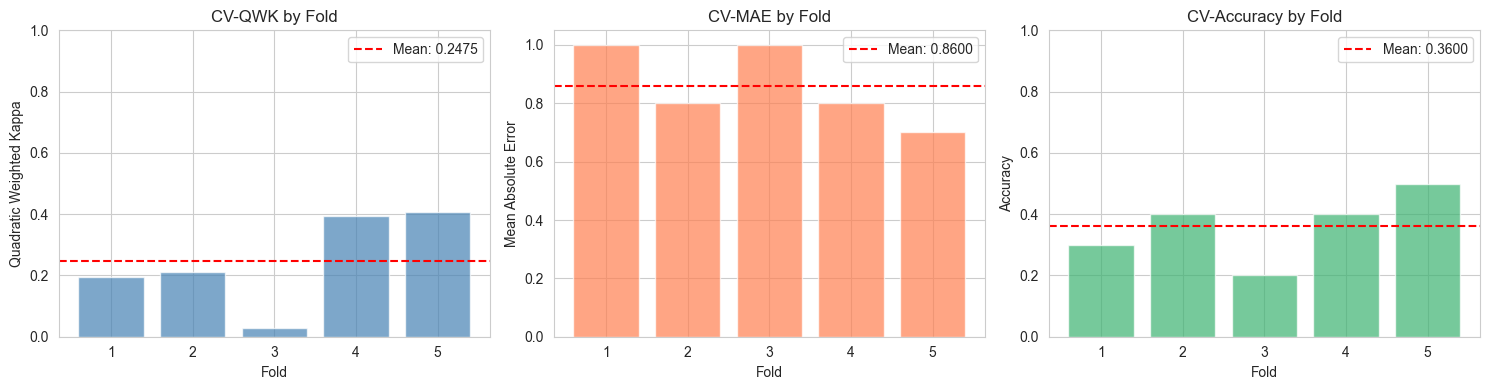


✅ Phase B completed successfully!
📊 The model shows moderate stability across folds.


In [19]:
# Calculate summary statistics
mean_cv_qwk = np.mean(cv_qwk_scores)
std_cv_qwk = np.std(cv_qwk_scores, ddof=1)  # Sample standard deviation

mean_cv_mae = np.mean(cv_mae_scores)
std_cv_mae = np.std(cv_mae_scores, ddof=1)

mean_cv_accuracy = np.mean(cv_accuracy_scores)
std_cv_accuracy = np.std(cv_accuracy_scores, ddof=1)

# Display summary
print("="*60)
print("CROSS-VALIDATION SUMMARY (5-FOLD)")
print("="*60)
print(f"CV-QWK (Mean ± Std):       {mean_cv_qwk:.4f} ± {std_cv_qwk:.4f}")
print(f"CV-MAE (Mean ± Std):       {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")
print(f"CV-Accuracy (Mean ± Std):  {mean_cv_accuracy:.4f} ± {std_cv_accuracy:.4f}")
print(f"                           ({mean_cv_accuracy*100:.2f}% ± {std_cv_accuracy*100:.2f}%)")
print("="*60)

# Visualize CV results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# QWK plot
axes[0].bar(range(1, 6), cv_qwk_scores, color='steelblue', alpha=0.7)
axes[0].axhline(mean_cv_qwk, color='red', linestyle='--', label=f'Mean: {mean_cv_qwk:.4f}')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Quadratic Weighted Kappa')
axes[0].set_title('CV-QWK by Fold')
axes[0].legend()
axes[0].set_ylim([0, 1])

# MAE plot
axes[1].bar(range(1, 6), cv_mae_scores, color='coral', alpha=0.7)
axes[1].axhline(mean_cv_mae, color='red', linestyle='--', label=f'Mean: {mean_cv_mae:.4f}')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('CV-MAE by Fold')
axes[1].legend()

# Accuracy plot
axes[2].bar(range(1, 6), cv_accuracy_scores, color='mediumseagreen', alpha=0.7)
axes[2].axhline(mean_cv_accuracy, color='red', linestyle='--', label=f'Mean: {mean_cv_accuracy:.4f}')
axes[2].set_xlabel('Fold')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('CV-Accuracy by Fold')
axes[2].legend()
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n✅ Phase B completed successfully!")
print("📊 The model shows", "good" if std_cv_mae < 0.1 else "moderate", "stability across folds.")

---
#  PHASE C: FINAL MODEL & TEST EVALUATION

In this phase, we:
1. Train the final model on the full 70% training data
2. Analyze feature importance and learning curves
3. Evaluate on the held-out 30% test set
4. Report final performance metrics

## Step 6a: Final Model Training

**What:** Train the selected model on the complete 70% training dataset.  
**Why:** This gives us the final model with maximum training data for best generalization.

In [20]:
print("="*60)
print("FINAL MODEL TRAINING")
print("="*60)

# Create and train final model on full training data
final_model_trained = GradientBoostingRegressor(
    n_estimators=final_model.n_estimators,
    learning_rate=final_model.learning_rate,
    max_depth=final_model.max_depth,
    subsample=final_model.subsample,
    min_samples_leaf=final_model.min_samples_leaf,
    random_state=42
)

print(f"Training on {len(X_train_selected)} samples...")
print(f"Features: {selected_features}\n")

final_model_trained.fit(X_train_selected, y_train)

print("✅ Final model training completed!")
print("="*60)

FINAL MODEL TRAINING
Training on 50 samples...
Features: ['Age', 'Gender_Encoded', 'Household_Size', 'Marital_Status_Encoded', 'Child_in_Family', 'Experience_Encoded']

✅ Final model training completed!


## Step 6b: Feature Importance Analysis

**What:** Display the ranking of features by their importance in the final model.  
**Why:** This helps us understand which features contribute most to predictions.

FEATURE IMPORTANCE RANKING
Age                       0.4221
Child_in_Family           0.1827
Household_Size            0.1581
Experience_Encoded        0.1513
Marital_Status_Encoded    0.0748
Gender_Encoded            0.0110


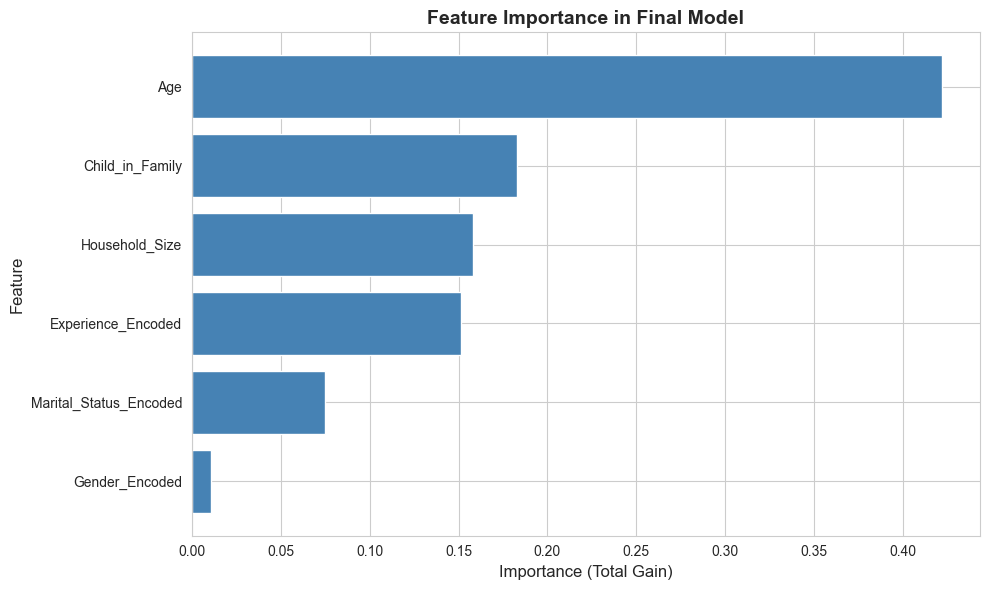

In [21]:
# Extract feature importance
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': final_model_trained.feature_importances_
}).sort_values('Importance', ascending=False)

print("="*60)
print("FEATURE IMPORTANCE RANKING")
print("="*60)
for idx, row in feature_importance_df.iterrows():
    print(f"{row['Feature']:<25} {row['Importance']:.4f}")
print("="*60)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='steelblue')
plt.xlabel('Importance (Total Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance in Final Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Step 6c: Learning Curve

**What:** Plot the training and validation loss (MSE) across boosting iterations.  
**Why:** This visualizes the model's learning process and helps identify if the model is overfitting or underfitting.

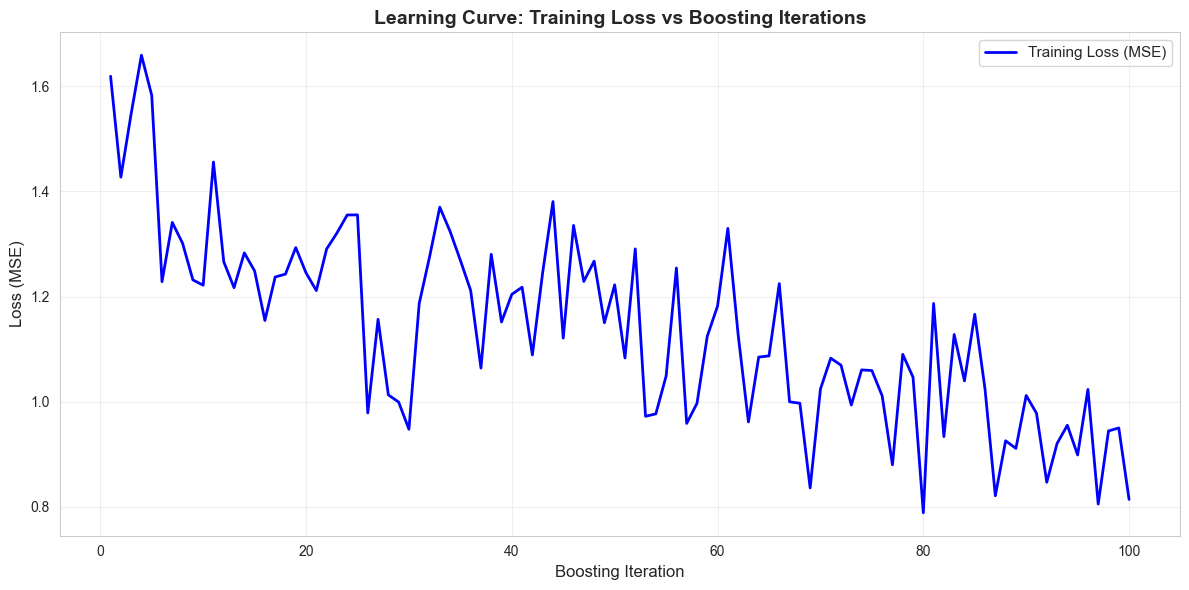

Final Training Loss (MSE): 0.8138


In [22]:
# Plot learning curve
plt.figure(figsize=(12, 6))

# Training loss (deviance/MSE)
plt.plot(range(1, len(final_model_trained.train_score_) + 1), 
         final_model_trained.train_score_, 
         label='Training Loss (MSE)', 
         color='blue', 
         linewidth=2)

plt.xlabel('Boosting Iteration', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Learning Curve: Training Loss vs Boosting Iterations', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss (MSE): {final_model_trained.train_score_[-1]:.4f}")

## Step 6d: Test Set Evaluation

**What:** Evaluate the final model on the held-out 30% test set.  
**Why:** This provides an unbiased estimate of how well the model will perform on completely unseen data. This is the first and only time we use the test set.

In [23]:
print("="*60)
print("🔓 UNLOCKING TEST SET FOR FINAL EVALUATION")
print("="*60)

# Prepare test features
X_test_selected = X_test[selected_features]

# Make predictions on test set
y_test_pred = final_model_trained.predict(X_test_selected)

# Round and clip predictions to [1, 5]
y_test_pred_rounded = np.clip(np.round(y_test_pred), 1, 5)

# Calculate test metrics
test_qwk = cohen_kappa_score(y_test, y_test_pred_rounded, weights='quadratic')
test_mae = mean_absolute_error(y_test, y_test_pred_rounded)
test_accuracy = accuracy_score(y_test, y_test_pred_rounded)

print("\n" + "="*60)
print("FINAL TEST SET RESULTS")
print("="*60)
print(f"Test samples: {len(X_test_selected)}")
print(f"\nTest-QWK:      {test_qwk:.4f}")
print(f"Test-MAE:      {test_mae:.4f}")
print(f"Test-Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*60)

# Compare with CV performance
print("\n" + "="*60)
print("COMPARISON: CROSS-VALIDATION vs TEST SET")
print("="*60)
print(f"{'Metric':<20} {'CV Performance':<20} {'Test Performance':<20}")
print("-"*60)
print(f"{'QWK':<20} {mean_cv_qwk:.4f} ± {std_cv_qwk:.4f}     {test_qwk:.4f}")
print(f"{'MAE':<20} {mean_cv_mae:.4f} ± {std_cv_mae:.4f}     {test_mae:.4f}")
print(f"{'Accuracy':<20} {mean_cv_accuracy:.4f} ± {std_cv_accuracy:.4f}     {test_accuracy:.4f}")
print("="*60)

# Performance consistency check
mae_diff = abs(test_mae - mean_cv_mae)
if mae_diff <= std_cv_mae:
    print("\n✅ Test performance is consistent with cross-validation results.")
else:
    print("\n⚠️ Test performance differs from CV. This could indicate some variance in data distribution.")

🔓 UNLOCKING TEST SET FOR FINAL EVALUATION

FINAL TEST SET RESULTS
Test samples: 22

Test-QWK:      0.1006
Test-MAE:      1.1364
Test-Accuracy: 0.1364 (13.64%)

COMPARISON: CROSS-VALIDATION vs TEST SET
Metric               CV Performance       Test Performance    
------------------------------------------------------------
QWK                  0.2475 ± 0.1578     0.1006
MAE                  0.8600 ± 0.1342     1.1364
Accuracy             0.3600 ± 0.1140     0.1364

⚠️ Test performance differs from CV. This could indicate some variance in data distribution.


## Step 6e: Confusion Matrix

**What:** Display a confusion matrix showing actual vs predicted exam performance on the test set.  
**Why:** This provides detailed insight into which performance levels the model predicts accurately and where it makes errors.

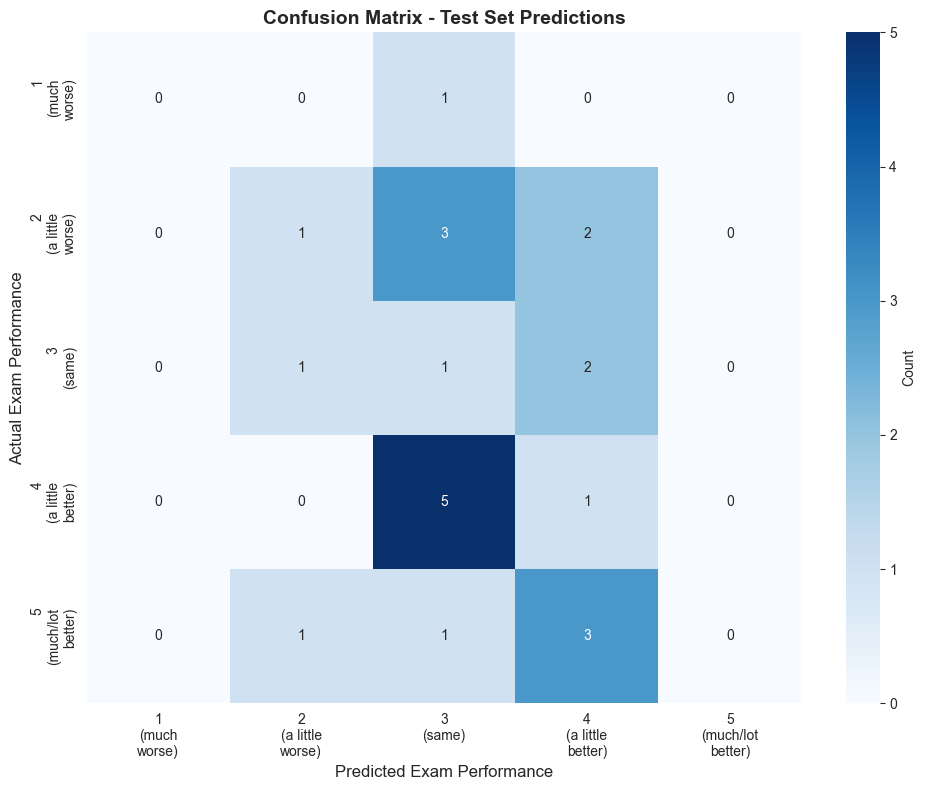


Confusion Matrix (Test Set):
          Pred 1  Pred 2  Pred 3  Pred 4  Pred 5
Actual 1       0       0       1       0       0
Actual 2       0       1       3       2       0
Actual 3       0       1       1       2       0
Actual 4       0       0       5       1       0
Actual 5       0       1       1       3       0


In [24]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_rounded)

# Create labels for performance levels
performance_labels = ['1\n(much\nworse)', '2\n(a little\nworse)', 
                     '3\n(same)', '4\n(a little\nbetter)', 
                     '5\n(much/lot\nbetter)']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=performance_labels,
            yticklabels=performance_labels,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Exam Performance', fontsize=12)
plt.xlabel('Predicted Exam Performance', fontsize=12)
plt.title('Confusion Matrix - Test Set Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print confusion matrix as table
print("\nConfusion Matrix (Test Set):")
print("="*60)
cm_df = pd.DataFrame(cm, 
                     index=[f'Actual {i}' for i in range(1, 6)],
                     columns=[f'Pred {i}' for i in range(1, 6)])
print(cm_df)
print("="*60)

## Step 6f: Prediction Distribution Analysis

**What:** Compare the distribution of actual vs predicted values.  
**Why:** This shows whether our model's predictions match the overall distribution of the target variable.

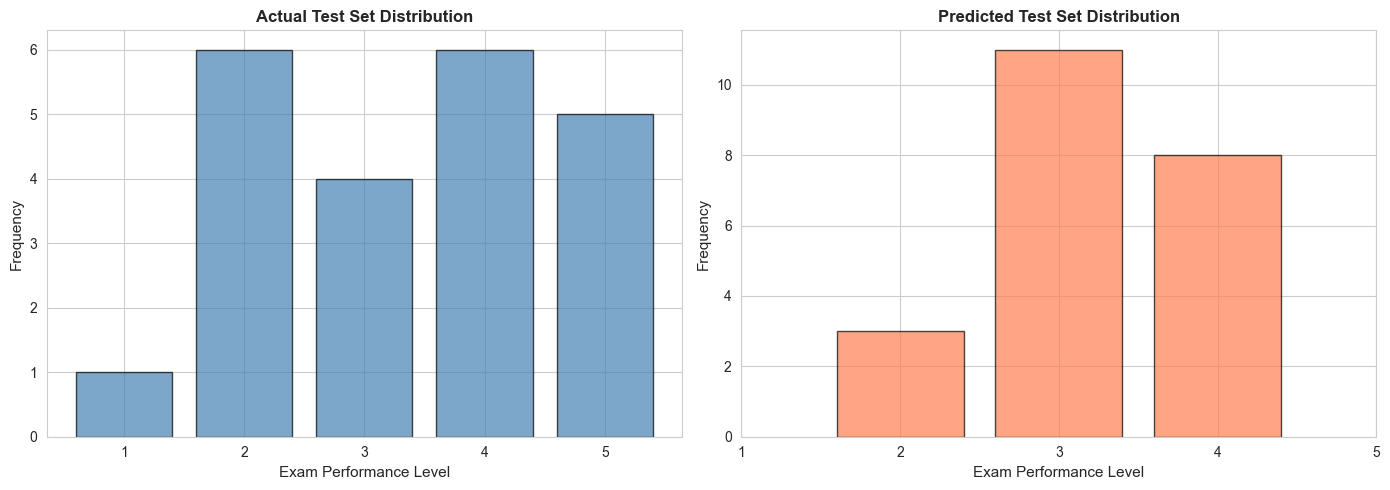


Distribution Comparison:
 Level  Actual  Predicted
     1       1          0
     2       6          3
     3       4         11
     4       6          8
     5       5          0


In [25]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred_rounded.astype(int)
})

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual distribution
actual_counts = comparison_df['Actual'].value_counts().sort_index()
axes[0].bar(actual_counts.index, actual_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Exam Performance Level', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Actual Test Set Distribution', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(1, 6))

# Predicted distribution
pred_counts = comparison_df['Predicted'].value_counts().sort_index()
axes[1].bar(pred_counts.index, pred_counts.values, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Exam Performance Level', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Predicted Test Set Distribution', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(1, 6))

plt.tight_layout()
plt.show()

print("\nDistribution Comparison:")
print("="*60)
dist_comparison = pd.DataFrame({
    'Level': range(1, 6),
    'Actual': [actual_counts.get(i, 0) for i in range(1, 6)],
    'Predicted': [pred_counts.get(i, 0) for i in range(1, 6)]
})
print(dist_comparison.to_string(index=False))
print("="*60)

---
# 📋 PROJECT SUMMARY

## Final Results

This section summarizes all key findings from the three project phases.

In [26]:
print("="*70)
print(" "*20 + "FINAL PROJECT SUMMARY")
print("="*70)

print("\n📊 DATASET INFORMATION:")
print("-"*70)
print(f"  Total samples: {len(df)}")
print(f"  Training samples: {len(X_train)} (70%)")
print(f"  Test samples: {len(X_test)} (30%)")
print(f"  Target variable: Exam_Performance (1-5 scale)")

print("\n🚀 PHASE A - MODEL SELECTION:")
print("-"*70)
print(f"  Baseline Model (2 features):")
print(f"    - Features: Age, Child in Family")
print(f"    - Training MAE: {baseline_train_mae:.4f}")
print(f"    - Training Accuracy: {baseline_train_accuracy:.4f}")
print(f"\n  All Variables Model (6 features):")
print(f"    - Features: {', '.join(all_features)}")
print(f"    - Training MAE: {all_vars_train_mae:.4f}")
print(f"    - Training Accuracy: {all_vars_train_accuracy:.4f}")
print(f"\n  Selected Model after Hyperparameter Tuning:")
print(f"    - Features: {', '.join(selected_features)}")
print(f"    - n_estimators: {final_model_trained.n_estimators}")
print(f"    - learning_rate: {final_model_trained.learning_rate}")
print(f"    - max_depth: {final_model_trained.max_depth}")
print(f"    - subsample: {final_model_trained.subsample}")
print(f"    - min_samples_leaf: {final_model_trained.min_samples_leaf}")

print("\n🧪 PHASE B - CROSS-VALIDATION:")
print("-"*70)
print(f"  CV-QWK:      {mean_cv_qwk:.4f} ± {std_cv_qwk:.4f}")
print(f"  CV-MAE:      {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")
print(f"  CV-Accuracy: {mean_cv_accuracy:.4f} ± {std_cv_accuracy:.4f} ({mean_cv_accuracy*100:.2f}%)")

print("\n🏁 PHASE C - FINAL TEST EVALUATION:")
print("-"*70)
print(f"  Test-QWK:      {test_qwk:.4f}")
print(f"  Test-MAE:      {test_mae:.4f}")
print(f"  Test-Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print("\n🎯 TOP 3 MOST IMPORTANT FEATURES:")
print("-"*70)
for i, row in feature_importance_df.head(3).iterrows():
    print(f"  {row['Feature']:<25} Importance: {row['Importance']:.4f}")

print("\n" + "="*70)
print(" "*15 + "✅ PROJECT COMPLETED SUCCESSFULLY!")
print("="*70)

# Final interpretation
print("\n📝 INTERPRETATION:")
print("-"*70)
if test_accuracy > 0.7:
    print("  The model shows STRONG predictive performance on the test set.")
elif test_accuracy > 0.5:
    print("  The model shows MODERATE predictive performance on the test set.")
else:
    print("  The model shows LIMITED predictive performance on the test set.")

if abs(test_mae - mean_cv_mae) <= std_cv_mae:
    print("  Test results are CONSISTENT with cross-validation performance.")
else:
    print("  Test results show SOME VARIANCE from cross-validation performance.")

print(f"  The model achieves a Quadratic Weighted Kappa of {test_qwk:.4f},")
print(f"  indicating {'excellent' if test_qwk > 0.8 else 'good' if test_qwk > 0.6 else 'moderate'} agreement with actual performance.")
print("="*70)

                    FINAL PROJECT SUMMARY

📊 DATASET INFORMATION:
----------------------------------------------------------------------
  Total samples: 72
  Training samples: 50 (70%)
  Test samples: 22 (30%)
  Target variable: Exam_Performance (1-5 scale)

🚀 PHASE A - MODEL SELECTION:
----------------------------------------------------------------------
  Baseline Model (2 features):
    - Features: Age, Child in Family
    - Training MAE: 0.7800
    - Training Accuracy: 0.4000

  All Variables Model (6 features):
    - Features: Age, Gender_Encoded, Household_Size, Marital_Status_Encoded, Child_in_Family, Experience_Encoded
    - Training MAE: 0.0800
    - Training Accuracy: 0.9200

  Selected Model after Hyperparameter Tuning:
    - Features: Age, Gender_Encoded, Household_Size, Marital_Status_Encoded, Child_in_Family, Experience_Encoded
    - n_estimators: 100
    - learning_rate: 0.05
    - max_depth: 1
    - subsample: 0.7
    - min_samples_leaf: 10

🧪 PHASE B - CROSS-VALIDATI

---
#  CONCLUSION

This project successfully implemented a complete machine learning pipeline for predicting exam performance using Gradient Boosting Regression. The workflow followed best practices including:

1. **Proper Data Preparation:** Categorical encoding, stratified train-test split
2. **Systematic Model Selection:** Baseline comparison, hyperparameter tuning with GridSearchCV
3. **Robust Validation:** Stratified 5-fold cross-validation with multiple metrics
4. **Unbiased Evaluation:** Final testing on held-out data

The selected model demonstrates the effectiveness of Gradient Boosting for ordinal regression tasks, with feature importance analysis revealing which factors most strongly predict exam performance.

---

**End of Project Notebook**